<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Churn-Prediction" data-toc-modified-id="Churn-Prediction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Churn Prediction</a></span><ul class="toc-item"><li><span><a href="#Problem-Statement" data-toc-modified-id="Problem-Statement-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Problem Statement</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Correlation-between-features" data-toc-modified-id="Correlation-between-features-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Correlation between features</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Feature importance</a></span><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Feature Engineering</a></span></li></ul></li></ul></li></ul></div>

# Churn Prediction

## Problem Statement

There is a telecom company that offers phone and internet services. There is a problem: some of our customers are churning. We would like to build a model that can identify the customers that are likely to churn. We have collected a dataset about our customers: what type of services they use, how much they paid, and how long they stayed with us. We also know who canceled their contracts and stopped using our services (churned). 

In this notebook, we are going to do feature correlation analysis and feature importance using random forest.

## Imports

In [9]:
# usual imports 
import numpy as np
import pandas as pd

import math

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from collections import defaultdict

# helper functions
from churn_prediction_utils import *

In [10]:
%store -r df_train_full_explore
%store -r df_train_full

%store -r y_train_full
%store -r y_train
%store -r y_val
%store -r y_test

%store -r categorical_features
%store -r numerical_features


## Correlation between features

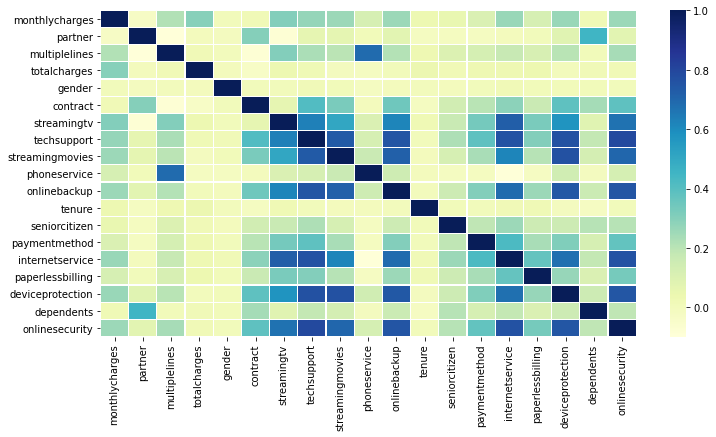

In [3]:
plt.figure(figsize=(12, 6))
corr_columns =  list(set(df_train_full_explore.columns) - set(['customerid', 'churn']))
corr = df_train_full_explore[corr_columns].apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

In [4]:
df_train_full_explore[numerical_features].corrwith(df_train_full_explore.churn).to_frame(name='Correlation with churn')

,Correlation with churn
tenure,-0.351885
monthlycharges,0.196805
totalcharges,-0.196353


In [5]:
# Calculate mutual information score between the pandas series and churn column
df_mi = df_train_full_explore[categorical_features].apply(calculate_mi, churn_column_values=df_train_full_explore.churn)
df_mi = df_mi.sort_values(ascending=False)
df_mi.to_frame(name='MI')

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


In [6]:
# Pearson correlation coefficient
df_train_full_explore[numerical_features].corrwith(df_train_full_explore.churn).to_frame(name='correlation')

,correlation
tenure,-0.351885
monthlycharges,0.196805
totalcharges,-0.196353


## Feature importance

We can get an idea of feature importance using Random forest classifier. Before we proceed with training Random Fores Classifier, we will have to do some feature engineering.

### Feature Engineering

We will use `DictVectorizer` to convert raw categorical data into data that can be understood by ML algorithm. `DictVectorizer` transforms lists of feature-value mappings to vectors.

In [7]:
res = get_input_data_matrix(df_train_full, categorical_features, numerical_features, scaling_required = False)
X_train_full_not_scaled = res['input_data_matrix']
feature_names = res['feature_names']

/Users/shubhamshukla/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:1487: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


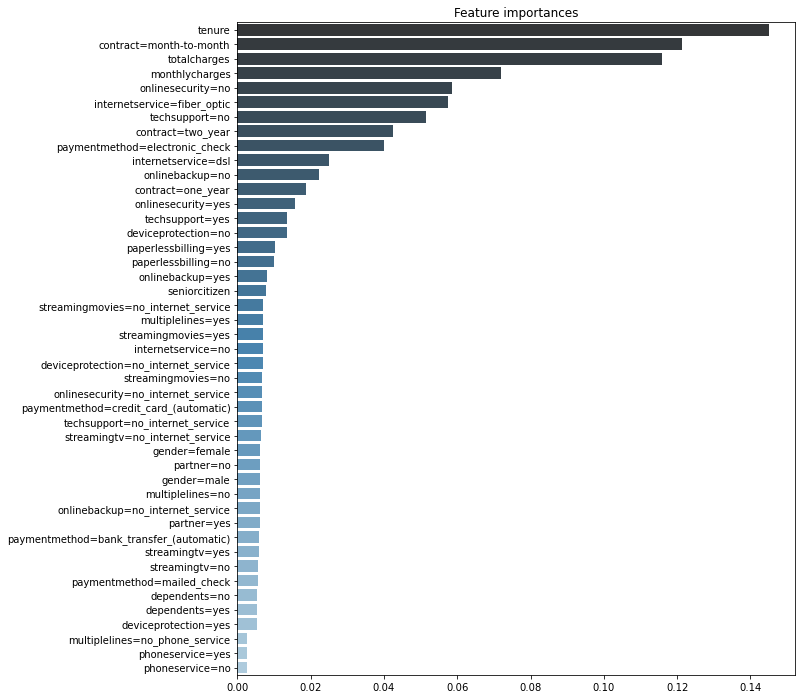

In [8]:
# Training Random Forest Classifier
params = {'random_state': 0, 'n_jobs': -1, 'n_estimators': 5000, 'max_depth': 8}
clf = RandomForestClassifier(**params)
clf = clf.fit(X_train_full_not_scaled, y_train_full)

# Prepare data for plotting feature importances
imp = pd.Series(data= clf.feature_importances_, index= feature_names).sort_values(ascending = False)

# Plot features importances
plt.figure(figsize=(10,12))
plt.title("Feature importances")
ax = sns.barplot(y= imp.index, x= imp.values, palette= "Blues_d", orient= 'h')

**Observations**
- Numerical features are quite important.
- Month to month contract feature is very important categorical feature.
- Features related to phone service are not critical to understanding whether a customer would churn or not.